In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from time import time
from preprocessing import preproc
import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nsl_kdd_train.csv to nsl_kdd_train.csv


In [ ]:
!ls

kddcup_train_10per.csv	preprocessing.py  __pycache__  sample_data


In [ ]:
X, y = preproc('kddcup_train_10per.csv')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [ ]:
y = np.transpose(y)

In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

 X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 14
compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(2 * encoding_dim, activation='relu')(encoder)
encoder = Dense(2 * encoding_dim, activation='relu')(encoder)

encoder = Dense(encoding_dim, activation='relu')(encoder)
encoder = Dense(2 * encoding_dim, activation='relu')(encoder)
encoder = Dense(2 * encoding_dim, activation='relu')(encoder)
encoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(encoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Compression factor: 2.9285714285714284
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 41)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 14)                588       
_________________________________________________________________
dense_10 (Dense)             (None, 28)                420       
_________________________________________________________________
dense_11 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_12 (Dense)             (None, 14)                406       
_________________________________________________________________
dense_13 (Dense)             (None, 28)                420       
_________________________________________________________________
dense_14 (Dense)             (None, 2

In [ ]:
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [ ]:
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=autoencoder.fit(X_train, X_train,epochs=2, batch_size=32, validation_data=(X_val, X_val), shuffle=True, verbose=1, 
                callbacks=[checkpointer, tensorboard]).history

Train on 316172 samples, validate on 79044 samples
Epoch 1/2
316172/316172 [==============================] - 16s 51us/step - loss: 3.1543 - acc: 0.6070 - val_loss: 3.1062 - val_acc: 0.6082
Epoch 2/2
316172/316172 [==============================] - 16s 50us/step - loss: 2.8905 - acc: 0.6807 - val_loss: 2.5515 - val_acc: 0.9237


In [ ]:
layer_names = [layer.name for layer in autoencoder.layers]
layer_name = layer_names[-3]
print(layer_name)
intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer(layer_name).output)
intermediate_output_test = intermediate_layer_model.predict(X_test)
intermediate_output_train = intermediate_layer_model.predict(X_train)

dense_14


In [ ]:
intermediate_output_test.shape

(98805, 28)

In [ ]:
classifier = RandomForestClassifier(n_estimators=20, random_state=0)  
classifier.fit(intermediate_output_train, y_train)  
y_pred = classifier.predict(intermediate_output_test)

In [ ]:
print(y_pred.shape)
print(y_test[67546])

(98805, 23)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


(20, 20)
[[  444     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0     1     0     0     0     0     0     0     0     0     4     0
      0     0     0     0     0     0     0     0]
 [    1     0     0     0     0     0     0     0     0     0     2     0
      0     0     0     0     0     0     0     0]
 [    0     0     0     8     0     0     0     0     0     0     3     0
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0     1     0
      0     0     0     0     0     0     0     0]
 [    4     0     0     0     0   243     0     0     0     8     3     0
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     1     2     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     2     0
      0     0     0     0     0     0     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


                  precision    recall  f1-score   support

           back.       1.00      1.00      1.00       444
buffer_overflow.       1.00      0.20      0.33         5
      ftp_write.       0.00      0.00      0.00         3
   guess_passwd.       1.00      0.73      0.84        11
           imap.       1.00      0.50      0.67         2
        ipsweep.       0.95      0.94      0.95       258
           land.       0.67      0.67      0.67         3
     loadmodule.       0.00      0.00      0.00         2
       multihop.       0.00      0.00      0.00         0
        neptune.       1.00      1.00      1.00     21498
           nmap.       0.73      0.48      0.58        46
         normal.       1.00      1.00      1.00     19428
           perl.       0.00      0.00      0.00         1
            phf.       0.00      0.00      0.00         0
            pod.       0.94      0.85      0.89        60
      portsweep.       0.95      0.90      0.93       187
        rootk

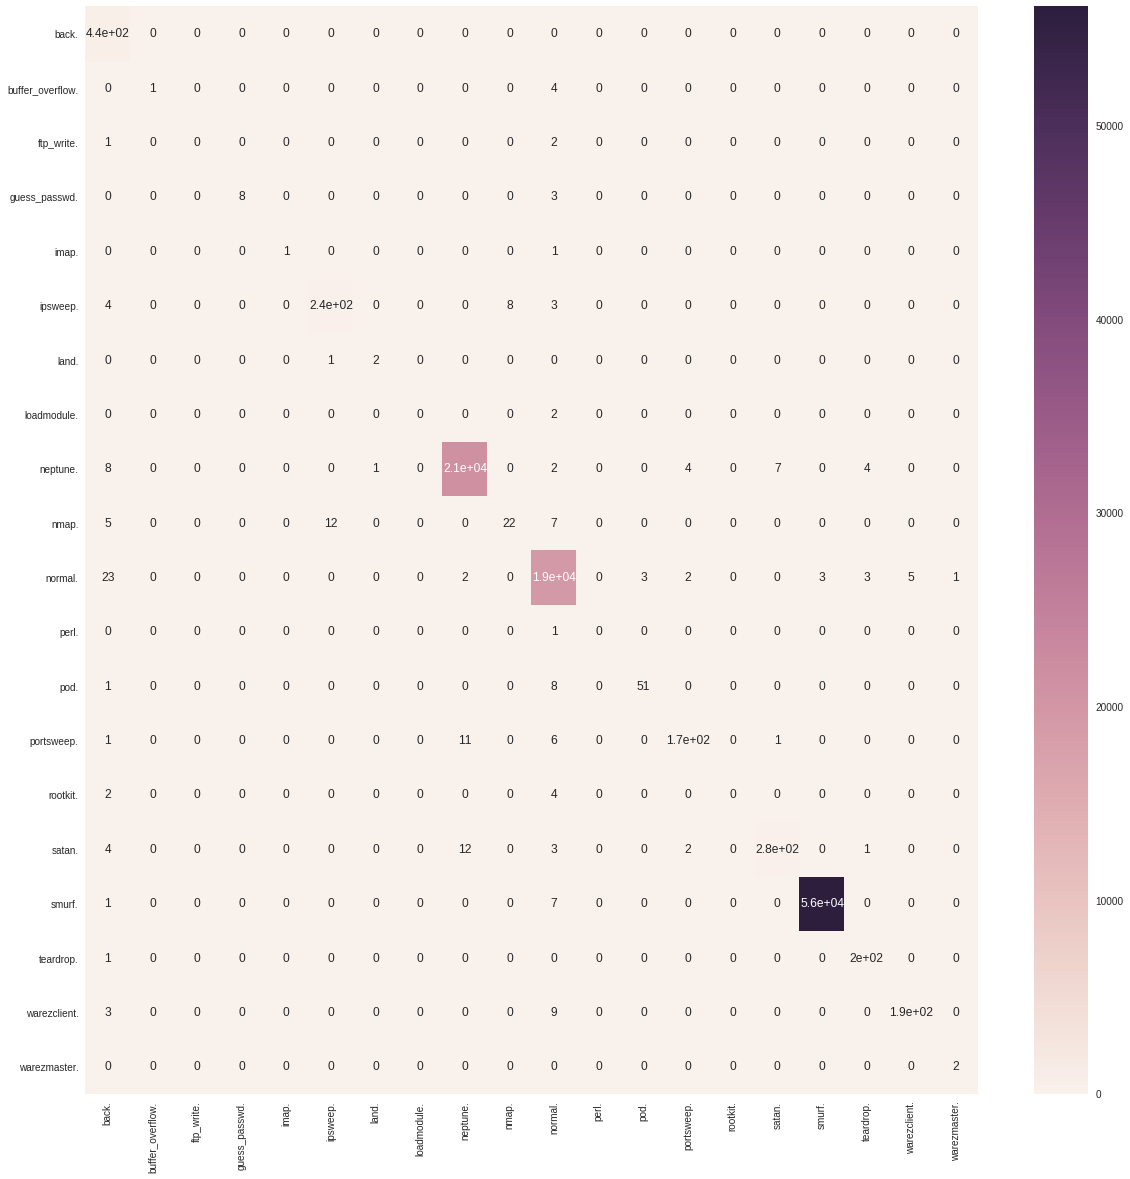

In [ ]:
import seaborn as sn

#print(confusion_matrix(y_test,y_pred))
y_test_non_category = [ np.argmax(t) for t in y_test ]
y_pred_non_category = [ np.argmax(t) for t in y_pred ]
#y_test_non_category = np.transpose(y_test_non_category)
#y_pred_non_category = np.transpose(y_pred_non_category)
target_names = output_names = ["back.", "buffer_overflow.", "ftp_write.", "guess_passwd.", "imap.", "ipsweep.", "land.", "loadmodule.", "multihop.", "neptune.", "nmap.", "normal.", "perl.", "phf.", "pod.", "portsweep.", "rootkit.", "satan.", "smurf.", "spy.", "teardrop.", "warezclient.", "warezmaster." ]
cm = confusion_matrix(y_test_non_category, y_pred_non_category)
print(cm.shape)
print(cm)
print(classification_report(y_test,y_pred, target_names=target_names))  
print(accuracy_score(y_test, y_pred)) 

cm_names = ["back.", "buffer_overflow.", "ftp_write.", "guess_passwd.", "imap.", "ipsweep.", "land.", "loadmodule.", "neptune.", "nmap.", "normal.", "perl.", "pod.", "portsweep.", "rootkit.", "satan.", "smurf.", "teardrop.", "warezclient.", "warezmaster." ]


#confusion matrix color map
df_cm = pd.DataFrame(cm, index=cm_names, columns=cm_names)
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)